In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from typing import List
import boto3

%load_ext autoreload
%autoreload 2

In [5]:
def rename_col(df: pd.DataFrame, old_name: str, new_name: str) -> pd.DataFrame:
    return df.rename({old_name: new_name}, axis=1)

def replace_comma_for_dot(df: pd.DataFrame, col_list: List[str]) -> pd.DataFrame:
    """Substitui vírgula por ponto em colunas que devem conter valores numéricos."""

    df[col_list] = df[col_list].apply(lambda col: col.str.replace(",", ".")).astype(float)

    return df

def round_column(df: pd.DataFrame, col: str, decimal_places: int = 2) -> pd.DataFrame:
    """Arredonda valores numéricos de uma coluna para uma certa quantidade de casas decimais"""

    df[col] = df[col].map(lambda x: round(x, decimal_places))

    return df

def convert_columns_to_lower_case(df: pd.DataFrame) -> pd.DataFrame:
    """Coloca todas as colunas do DataFrame em caixa baixa."""

    df = df.rename({col:col.lower() for col in df.columns}, axis=1)

    return df

def convert_to_datetime(df: pd.DataFrame, time_col: str, format: str = '%Y%m') -> pd.DataFrame:

    df[time_col] = pd.to_datetime(df[time_col], format=format)

    return df

def load_data_path() -> str:
    return "/Users/rafaelmacedo/Documents/Code/ouropreto-puc-minas/data/"

In [6]:
DATA_PATH = load_data_path()

### 2.1. Tratamento dos dados (qualidade)

In [7]:
macro_data = pd.read_csv(DATA_PATH + "tb_dados_macro.csv", sep=';')
macro_data = (
    macro_data
    .pipe(convert_columns_to_lower_case)
    .pipe(replace_comma_for_dot, col_list=["ipca", "selic", "cambio"])
    .pipe(convert_to_datetime, 'dt_posicao')
    .pipe(rename_col, 'dt_posicao', 'safra')
    )

tb_combustiveis = pd.read_csv(DATA_PATH + "tb_preco_combustiveis.csv", sep=';')
tb_combustiveis = (
    tb_combustiveis
    .pipe(convert_columns_to_lower_case)
    .pipe(replace_comma_for_dot, col_list=["valor_medio"])
    .pipe(convert_to_datetime, 'dt_base')
    .pipe(rename_col, 'dt_base', 'safra')
    )

tb_gasolina = pd.read_csv(DATA_PATH + "tb_preco_nacional_gasolina.csv", sep=';')
tb_gasolina = (
    tb_gasolina
    .pipe(convert_columns_to_lower_case)
    .pipe(replace_comma_for_dot, col_list=["valor_medio"])
    .pipe(convert_to_datetime, 'dt_base')
    .pipe(rename_col, 'dt_base', 'safra')
    )

In [15]:
if isinstance(tb_combustiveis, pd.DataFrame): print(True)
else: print(False)

True


In [11]:
tb_combustiveis[tb_combustiveis['produto'] == "GASOLINA"]

,safra,regiao_sigla,estado_sigla,municipio,produto,valor_medio,unidade_de_medida,bandeira
34696,2016-01-01,CO,DF,BRASILIA,GASOLINA,3.780000,R$ / litro,ALESAT
34697,2016-01-01,CO,DF,BRASILIA,GASOLINA,3.906000,R$ / litro,BRANCA
34698,2016-01-01,CO,DF,BRASILIA,GASOLINA,3.927468,R$ / litro,IPIRANGA
34699,2016-01-01,CO,DF,BRASILIA,GASOLINA,3.916476,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
34700,2016-01-01,CO,DF,BRASILIA,GASOLINA,3.916472,R$ / litro,RAIZEN
...,...,...,...,...,...,...,...,...
775907,2021-09-01,SE,SP,VOTUPORANGA,GASOLINA,6.116500,R$ / litro,VIBRA ENERGIA
775908,2021-11-01,SE,SP,VOTUPORANGA,GASOLINA,5.759500,R$ / litro,VIBRA ENERGIA
775909,2021-12-01,SE,SP,VOTUPORANGA,GASOLINA,5.799000,R$ / litro,IPIRANGA
775910,2021-12-01,SE,SP,VOTUPORANGA,GASOLINA,5.789000,R$ / litro,RAIZEN


## 3. Modelagem de séries temporais

### 3.1. Diferenciação da série

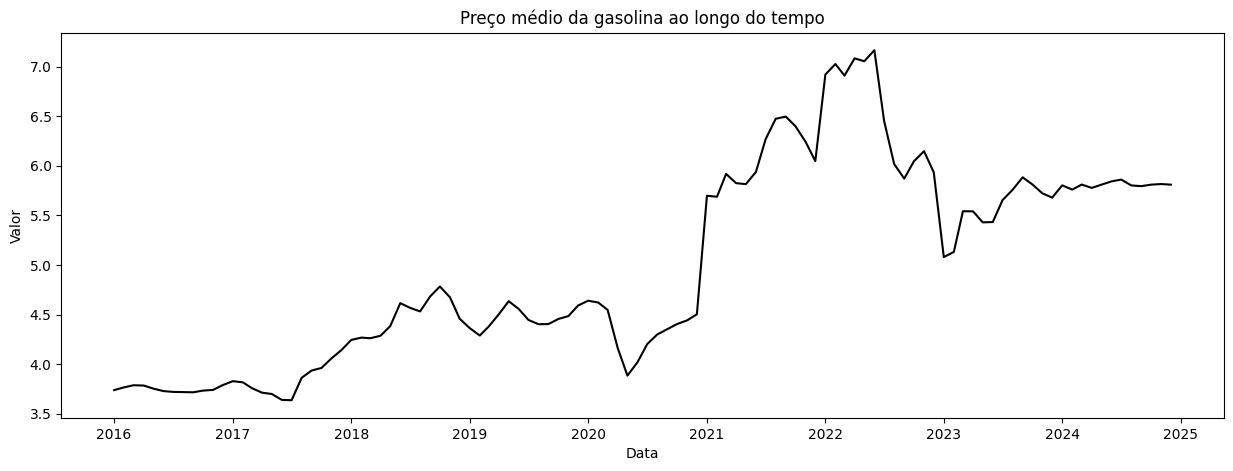

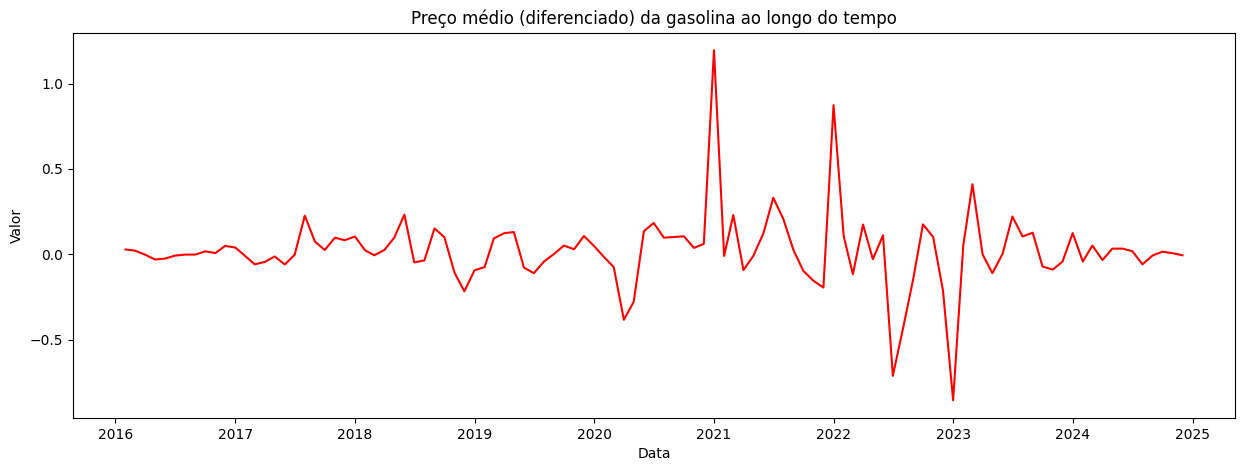

In [104]:
# Diferenciação da série
tb_gasolina_diff = tb_gasolina.copy()
tb_gasolina_diff['valor_medio_diff'] = tb_gasolina_diff['valor_medio'].diff()

# Remoção dos valores NaN devido à diferenciação
tb_gasolina_diff = tb_gasolina_diff.dropna()

plt.figure(figsize=(15, 5))
sns.lineplot(tb_gasolina, x='safra', y='valor_medio', color='black')
plt.title('Preço médio da gasolina ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

plt.figure(figsize=(15, 5))
sns.lineplot(tb_gasolina_diff, x='safra', y='valor_medio_diff', color='red')
plt.title('Preço médio (diferenciado) da gasolina ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

### 3.2. Funções de autocorrelação

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

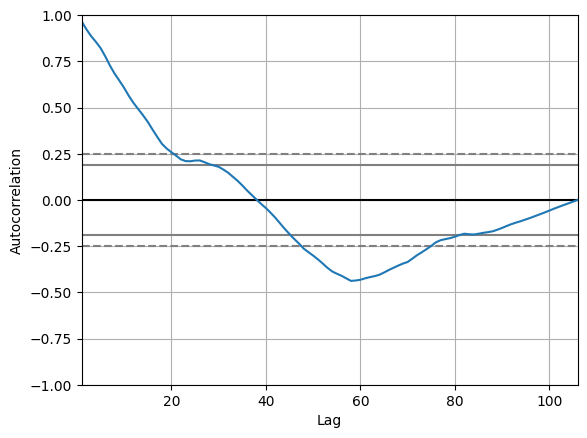

In [123]:
autocorrelation_plot(tb_gasolina_diff['valor_medio'])

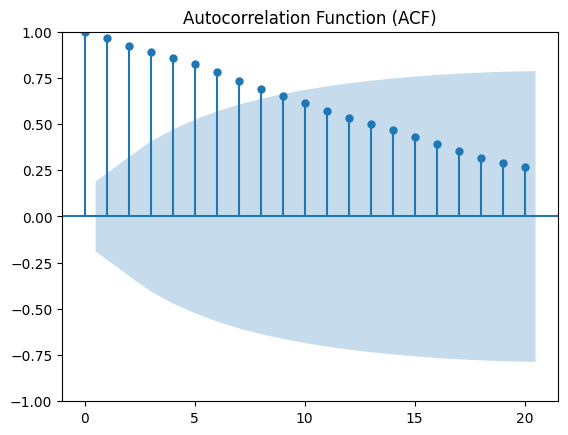

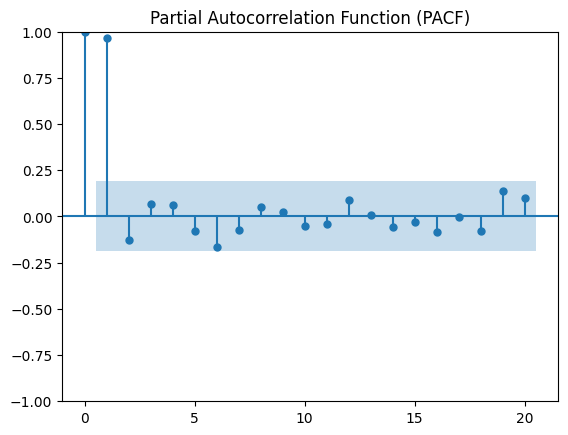

In [124]:
# Autocorrelation Plot
plot_acf(tb_gasolina['valor_medio'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Partial Autocorrelation Plot
plot_pacf(tb_gasolina['valor_medio'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

### 3.3. Augmented Dickey-Fuller test para medição de estacionariedade

In [107]:
# Perform ADF test
# Hipótese nula: a série não é estacionária
# Hipótese alternativa: a série é estacionária

adf_test = adfuller(tb_gasolina['valor_medio'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] < 0.05:
    print("A série é estacionária (nível de significância em 0.05).")
else:
    print("A série não é estacionária (nível de significância em 0.05).")

ADF Statistic: -1.482988721732431
p-value: 0.5419091650338732
A série não é estacionária (nível de significância em 0.05).


                               SARIMAX Results                                
Dep. Variable:       valor_medio_diff   No. Observations:                  106
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   9.812
Date:                Thu, 22 Aug 2024   AIC                            -13.625
Time:                        20:25:26   BIC                             -5.663
Sample:                             0   HQIC                           -10.399
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1650      0.088      1.874      0.061      -0.008       0.338
ma.L1         -0.9985      0.539     -1.852      0.064      -2.055       0.058
sigma2         0.0466      0.024      1.952      0.0

/Users/rafaelmacedo/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rafaelmacedo/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rafaelmacedo/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rafaelmacedo/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA

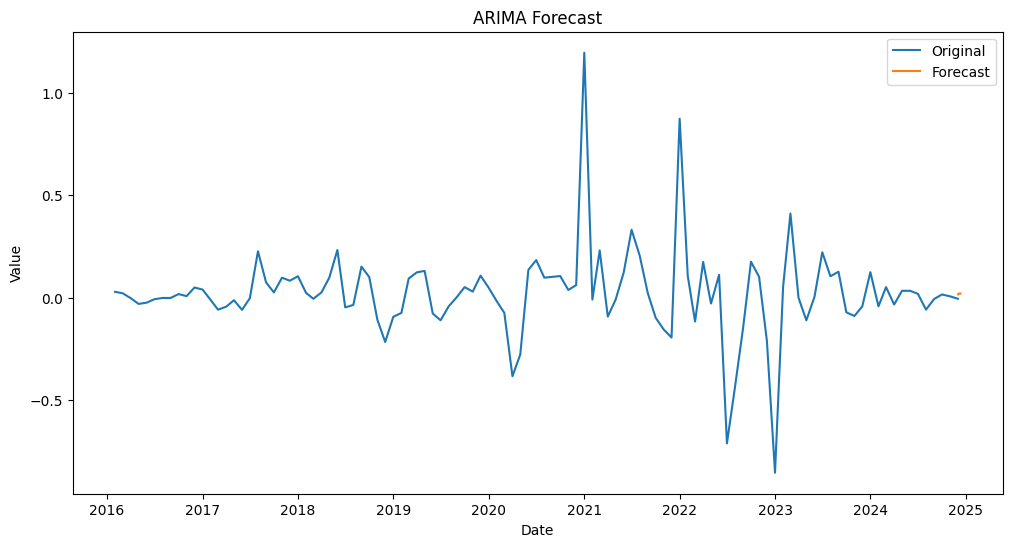

In [120]:
from statsmodels.tsa.arima.model import ARIMA

# Build the model
#tb_gasolina_diff = tb_gasolina_diff.set_index('safra')
model = ARIMA(tb_gasolina_diff['valor_medio_diff'], order=(1, 1, 1))
arima_result = model.fit()

# Print model summary
print(arima_result.summary())

# Forecast
forecast = arima_result.forecast(steps=10)
print(forecast)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(tb_gasolina_diff.index, tb_gasolina_diff['valor_medio_diff'], label='Original')
plt.plot(pd.date_range(tb_gasolina_diff.index[-1], periods=11, freq='M')[1:], forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()